In [1]:
import gzip
from typing import Dict
import torch
import torch.nn.functional as F
import pickle

import cv2
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt
from PIL import ImageColor
import numpy.typing as npt


In [61]:
a = np.array([-1,1,-1.5,1.5])
print(a)
print(a.astype(np.int32))

[-1.   1.  -1.5  1.5]
[-1  1 -1  1]


In [92]:
bev_pixel_height = 8
bev_pixel_width = 8
bev_pixel_size = 0.25

def bev_semantic_frame():
        return (bev_pixel_height, bev_pixel_width)

coords = np.array([[-0.5,0], [-0.75,0], [-0.5,0.25], [-0.75,0.25]])
# coords = np.array([[0.5,0], [0.75,0], [0.5,0.25], [0.75,0.25]])

map_polygon_mask = np.zeros(bev_semantic_frame()[::-1], dtype=np.uint8)

# pixel_center = np.array([[0, bev_pixel_width / 2.0]])
pixel_center = np.array([[bev_pixel_height / 2.0, bev_pixel_width / 2.0]])

coords_idcs = (coords / bev_pixel_size) + pixel_center
# coords_idcs = coords / bev_pixel_size

# print(coords_idcs)
result = coords_idcs.astype(np.int32)
print(result)

# print(map_polygon_mask)
# print(map_polygon_mask)
cv2.fillPoly(map_polygon_mask, [result], color=255)
# print(map_polygon_mask)
map_polygon_mask = np.rot90(map_polygon_mask)
print(map_polygon_mask)
# print(map_polygon_mask > 0)

[[2 4]
 [1 4]
 [2 5]
 [1 5]]
[[  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0 255 255   0   0]
 [  0   0   0   0 255 255   0   0]
 [  0   0   0   0   0   0   0   0]]


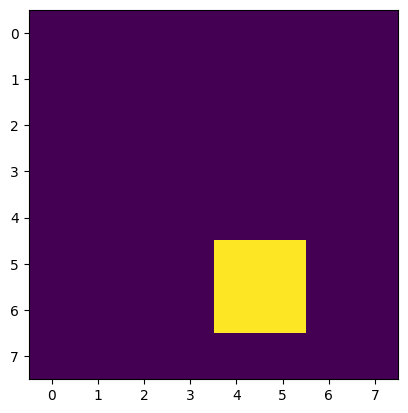

In [93]:
plt.imshow(map_polygon_mask)

In [2]:
class tmp():
    _config = None
    _num_rows = 2
    _num_columns = 2
    _num_plots = 3

In [3]:
def semantic_map_to_rgb(semantic_map: npt.NDArray[np.int64], config) -> npt.NDArray[np.uint8]:
    """
    Convert semantic map to RGB image.
    :param semantic_map: numpy array of segmentation map (multi-channel)
    :param config: global config dataclass of Pseudolab
    :return: RGB image as numpy array
    """

    height, width = semantic_map.shape[:2]
    rgb_map = np.ones((height, width, 3), dtype=np.uint8) * 255

    for label in range(1, 7):
        hex_color = "#D3D3D3"
        rgb_map[semantic_map == label] = ImageColor.getcolor(hex_color, "RGB")
    return rgb_map[::-1, ::-1]

In [4]:
with gzip.open("./2a5511445010561f/pseudolab_v2_feature.gz", "rb") as f:
    features: Dict[str, torch.Tensor] = pickle.load(f)

with gzip.open("./2a5511445010561f/pseudolab_v2_target.gz", "rb") as f:
    targets: Dict[str, torch.Tensor] = pickle.load(f)

print(features["camera_feature"].shape)
features["camera_feature"].unsqueeze_(-1)
features["camera_feature"] = features["camera_feature"].permute(3,0,1,2)
print(features["camera_feature"].shape)
print()
print(targets["bev_semantic_map"].shape)
targets["bev_semantic_map"].unsqueeze_(-1)
targets["bev_semantic_map"] = targets["bev_semantic_map"].permute(2,0,1)
print(targets["bev_semantic_map"].shape)
print()
print(targets["agent_labels"].shape)
targets["agent_labels"].unsqueeze_(-1)
targets["agent_labels"] = targets["agent_labels"].permute(1,0)
print(targets["agent_labels"].shape)
print()
print(targets["agent_states"].shape)
targets["agent_states"].unsqueeze_(-1)
targets["agent_states"] = targets["agent_states"].permute(2,0,1)
print(targets["agent_states"].shape)
print()
print(targets["trajectory"].shape)
targets["trajectory"].unsqueeze_(-1)
targets["trajectory"] = targets["trajectory"].permute(2,0,1)
print(targets["trajectory"].shape)

torch.Size([3, 256, 2304])
torch.Size([1, 3, 256, 2304])

torch.Size([256, 256])
torch.Size([1, 256, 256])

torch.Size([30])
torch.Size([1, 30])

torch.Size([30, 5])
torch.Size([1, 30, 5])

torch.Size([8, 3])
torch.Size([1, 8, 3])


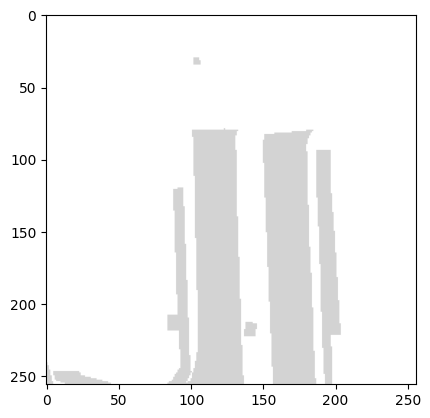

In [13]:
bev = targets["bev_semantic_map"].numpy()
sample_idx = 0
plt.imshow(semantic_map_to_rgb(bev[sample_idx], tmp._config))

In [12]:
camera = features["camera_feature"].permute(0, 2, 3, 1).numpy()
bev = targets["bev_semantic_map"].numpy()
# lidar_map = features["lidar_feature"].squeeze(1).numpy()
agent_labels = targets["agent_labels"].numpy()
agent_states = targets["agent_states"].numpy()
trajectory = targets["trajectory"].numpy()

pred_bev = bev
pred_agent_labels = agent_labels
pred_agent_states = agent_states
pred_trajectory = trajectory

plots = []
cam_h, cam_w = camera[0].shape[:2]
bev_h, bev_w = bev[0].shape[:2]
for sample_idx in range(tmp._num_rows * tmp._num_columns):
    sample_idx = 0
    plot = np.zeros((cam_h//2 + bev_h, cam_w//2 , 3), dtype=np.uint8)
    print(plot.shape, cam_h, cam_w, bev_h, bev_w)
    plot[:cam_h//2, :] = (camera[sample_idx] * 255).astype(np.uint8)[::2, ::2]

    start_w = 0
    plot[cam_h//2:, start_w:start_w + bev_w] = semantic_map_to_rgb(bev[sample_idx], tmp._config)
    start_w = (cam_w//2) // 3 * 1
    plot[cam_h//2:, start_w:start_w + bev_w] = semantic_map_to_rgb(pred_bev[sample_idx], tmp._config)

    agent_states_ = agent_states[sample_idx][agent_labels[sample_idx]]
    pred_agent_states_ = pred_agent_states[sample_idx][pred_agent_labels[sample_idx] > 0.5]

    start_w = (cam_w//2) // 3 * 2
    plot[cam_h//2:, start_w:start_w + bev_w] = semantic_map_to_rgb(bev[sample_idx], tmp._config)

    plots.append(torch.tensor(plot).permute(2, 0, 1))

PROBE = f"{camera.shape}\n{bev.shape}\n{agent_labels.shape}\n{agent_states.shape}\n{trajectory.shape}"
print(PROBE)

(384, 1152, 3) 256 2304 256 256
(384, 1152, 3) 256 2304 256 256
(384, 1152, 3) 256 2304 256 256
(384, 1152, 3) 256 2304 256 256
(1, 256, 2304, 3)
(1, 256, 256)
(1, 30)
(1, 30, 5)
(1, 8, 3)


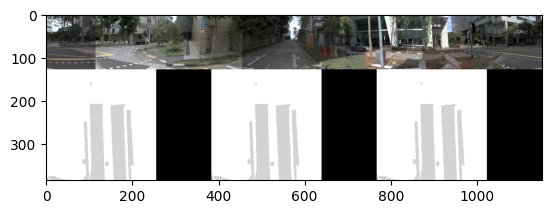

In [10]:
plt.imshow(plots[-1].permute(1,2,0))

In [2]:
def load_image(img_root: str) -> dict:

    imgs = {
        'cam_l0' : ... , 'cam_l1' : ... , 'cam_l2' : ... , 'cam_f0' : ... ,
        'cam_r0' : ... , 'cam_r1' : ... , 'cam_r2' : ... , 'cam_b0' : ... ,
    }

    for k in imgs.keys():
        img_path = f"{img_root}/{k}.jpeg"
        img = np.asarray(Image.open(img_path))
        # img = cv2.imread(img_path, mode='RGB')
        imgs[k] = img
    
    return imgs

def _crop_by_ltf(imgs: dict, reverse: bool = False, verbose: bool = True, ):

    # Latent TransFuser Version
    print("----------------------------------")
    print("Crop by LTF")
    l0 = imgs['cam_l0'][28:-28, 416:-416]
    f0 = imgs['cam_f0'][28:-28]
    r0 = imgs['cam_r0'][28:-28, 416:-416]
    
    if reverse:
        l0 = imgs['cam_l2'][28:-28]
        f0 = imgs['cam_b0'][28:-28]
        r0 = imgs['cam_r2'][28:-28]

    if verbose:
        print(f"\n \
            l0 : {imgs['cam_l0'].shape} -> {l0.shape}\n \
            f0 : {imgs['cam_f0'].shape} -> {f0.shape}\n \
            r0 : {imgs['cam_r0'].shape} -> {r0.shape}")

    print("Stitched")
    ltf_stitched_image = np.concatenate([l0, f0, r0], axis=1)
    if verbose: print(ltf_stitched_image.shape)
    ltf_resized_image = cv2.resize(ltf_stitched_image, (1024, 256))
    print("Resized")
    if verbose: print(ltf_resized_image.shape)

    return ltf_resized_image, ltf_stitched_image

def crop_by_custom(imgs: dict, height: int = 28, width: list = [1,1,1,1], resize: list = [256*9, 256], verbose: bool = True):

    # Latent TransFuser Version
    print("----------------------------------")
    print("Crop by custom")
    # f0 = imgs['cam_f0'][height:-1*height,width[0]:-1*width[0]]
    # l2 = imgs['cam_l2'][height:-1*height,width[3]:-1*width[3]]
    # l1 = imgs['cam_l1'][height:-1*height,width[2]:-1*width[2]]
    # l0 = imgs['cam_l0'][height:-1*height,width[1]:-1*width[1]]
    # r0 = imgs['cam_r0'][height:-1*height,width[1]:-1*width[1]]
    # r1 = imgs['cam_r1'][height:-1*height,width[2]:-1*width[2]]
    # r2 = imgs['cam_r2'][height:-1*height,width[3]:-1*width[3]]

    # f0 = imgs['cam_f0'][height:-1*height]
    # l2 = imgs['cam_l2'][height:-1*height,:-1*width[3]]
    # l1 = imgs['cam_l1'][height:-1*height,:-1*width[2]]
    # l0 = imgs['cam_l0'][height:-1*height,:-1*width[1]]
    # r0 = imgs['cam_r0'][height:-1*height,width[1]:]
    # r1 = imgs['cam_r1'][height:-1*height,width[2]:]
    # r2 = imgs['cam_r2'][height:-1*height,width[3]:]

    l2 = imgs['cam_l2'][28:-28, :-1000]
    l1 = imgs['cam_l1'][28:-28, :-612]
    l0 = imgs['cam_l0'][28:-28, :-500]
    f0 = imgs['cam_f0'][28:-28]
    r0 = imgs['cam_r0'][28:-28, 500:]
    r1 = imgs['cam_r1'][28:-28, 612:]
    r2 = imgs['cam_r2'][28:-28, 1000:]
    
    if verbose:
        print(f"\n \
            l2 : {imgs['cam_l2'].shape} -> {l2.shape}\n \
            l1 : {imgs['cam_l1'].shape} -> {l1.shape}\n \
            l0 : {imgs['cam_l0'].shape} -> {l0.shape}\n \
            f0 : {imgs['cam_f0'].shape} -> {f0.shape}\n \
            r0 : {imgs['cam_r0'].shape} -> {r0.shape}\n \
            r1 : {imgs['cam_r1'].shape} -> {r1.shape}\n \
            r2 : {imgs['cam_r2'].shape} -> {r2.shape}")

    print("Stitched")
    pdl_stitched_image = np.concatenate([l2, l1, l0, f0, r0, r1, r2], axis=1)
    if verbose: print(pdl_stitched_image.shape)
    pdl_resized_image = cv2.resize(pdl_stitched_image, resize)
    print("Resized")
    if verbose: print(pdl_resized_image.shape)

    return pdl_resized_image, pdl_stitched_image

In [3]:
"""
             l2 : (1080, 1920, 3) -> (1024, 1016, 3)
             l1 : (1080, 1920, 3) -> (1024, 1216, 3)
             l0 : (1080, 1920, 3) -> (1024, 1416, 3)
             f0 : (1080, 1920, 3) -> (1024, 1920, 3)
             r0 : (1080, 1920, 3) -> (1024, 1416, 3)
             r1 : (1080, 1920, 3) -> (1024, 1216, 3)
             r2 : (1080, 1920, 3) -> (1024, 1016, 3)

             l2 : (1080, 1920, 3) -> (1024, 1016, 3)
             l1 : (1080, 1920, 3) -> (1024, 1216, 3)
             l0 : (1080, 1920, 3) -> (1024, 1416, 3)
             f0 : (1080, 1920, 3) -> (1024, 1920, 3)
             r0 : (1080, 1920, 3) -> (1024, 1416, 3)
             r1 : (1080, 1920, 3) -> (1024, 1216, 3)
             r2 : (1080, 1920, 3) -> (1024, 1016, 3)

"""

'\n             l2 : (1080, 1920, 3) -> (1024, 1016, 3)\n             l1 : (1080, 1920, 3) -> (1024, 1216, 3)\n             l0 : (1080, 1920, 3) -> (1024, 1416, 3)\n             f0 : (1080, 1920, 3) -> (1024, 1920, 3)\n             r0 : (1080, 1920, 3) -> (1024, 1416, 3)\n             r1 : (1080, 1920, 3) -> (1024, 1216, 3)\n             r2 : (1080, 1920, 3) -> (1024, 1016, 3)\n\n             l2 : (1080, 1920, 3) -> (1024, 1016, 3)\n             l1 : (1080, 1920, 3) -> (1024, 1216, 3)\n             l0 : (1080, 1920, 3) -> (1024, 1416, 3)\n             f0 : (1080, 1920, 3) -> (1024, 1920, 3)\n             r0 : (1080, 1920, 3) -> (1024, 1416, 3)\n             r1 : (1080, 1920, 3) -> (1024, 1216, 3)\n             r2 : (1080, 1920, 3) -> (1024, 1016, 3)\n\n'

----------------------------------
Crop by LTF

             l0 : (1080, 1920, 3) -> (1024, 1088, 3)
             f0 : (1080, 1920, 3) -> (1024, 1920, 3)
             r0 : (1080, 1920, 3) -> (1024, 1088, 3)
Stitched
(1024, 4096, 3)
Resized
(256, 1024, 3)
----------------------------------
Crop by LTF

             l0 : (1080, 1920, 3) -> (1024, 1920, 3)
             f0 : (1080, 1920, 3) -> (1024, 1920, 3)
             r0 : (1080, 1920, 3) -> (1024, 1920, 3)
Stitched
(1024, 5760, 3)
Resized
(256, 1024, 3)
----------------------------------
Crop by custom

             l2 : (1080, 1920, 3) -> (1024, 920, 3)
             l1 : (1080, 1920, 3) -> (1024, 1308, 3)
             l0 : (1080, 1920, 3) -> (1024, 1420, 3)
             f0 : (1080, 1920, 3) -> (1024, 1920, 3)
             r0 : (1080, 1920, 3) -> (1024, 1420, 3)
             r1 : (1080, 1920, 3) -> (1024, 1308, 3)
             r2 : (1080, 1920, 3) -> (1024, 920, 3)
Stitched
(1024, 9216, 3)
Resized
(256, 2304, 3)


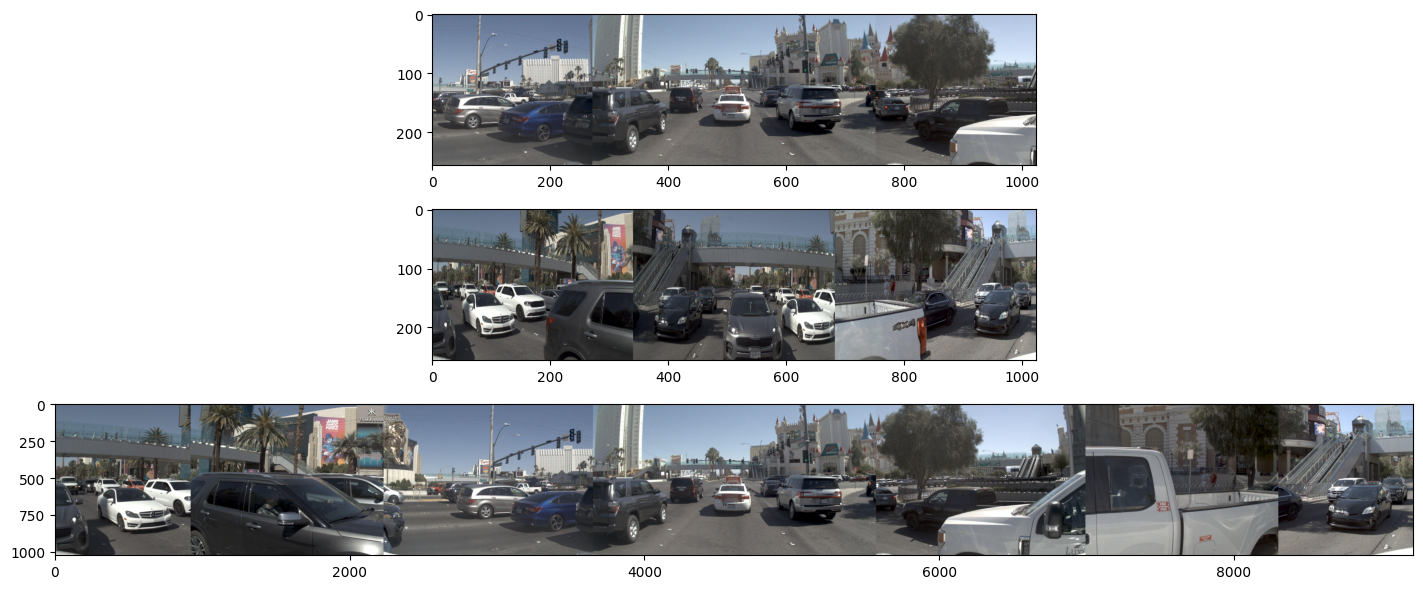

In [4]:
img_root = './viz_sample/2ca53077a0a35b6d/2021.07.16.18.19.22_veh-35_00440_00858/3'
img_root = './viz_sample/762599cde95156ff/2021.06.07.18.53.26_veh-26_00005_00427/3'
img_root = './viz_sample/8212323415cf509a/2021.10.01.19.16.42_veh-28_03307_03808/3'
img_root = './viz_sample/ac0c803827d65b80/2021.05.12.22.00.38_veh-35_01008_01518/3'
# img_root = './viz_sample/ead69cf7d81b5a39/2021.06.07.18.53.26_veh-26_00005_00427/3'

imgs = load_image(img_root)

# Latent TransFuser Version
ltf_resized_image, _ = _crop_by_ltf(imgs)
ltf_resized_r_image, _ = _crop_by_ltf(imgs, reverse=True)

# Pseudolab Version
pdl_resized_image, pdl_stitched_image = crop_by_custom(imgs, width=[4,266,266,266])

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(18, 6))
axs[0].imshow(ltf_resized_image)
axs[1].imshow(ltf_resized_r_image)
axs[2].imshow(pdl_stitched_image)
# axs[2].imshow(pdl_resized_image)
plt.tight_layout()

In [56]:
a,b,c, = (1024, 9440, 3)

print(b/a, a*9, b-a*9)

9.21875 9216 224


----------------------------------
Crop by custom
Stitched
Resized
----------------------------------
Crop by custom
Stitched
Resized
----------------------------------
Crop by custom
Stitched
Resized
----------------------------------
Crop by custom
Stitched
Resized
----------------------------------
Crop by custom
Stitched
Resized


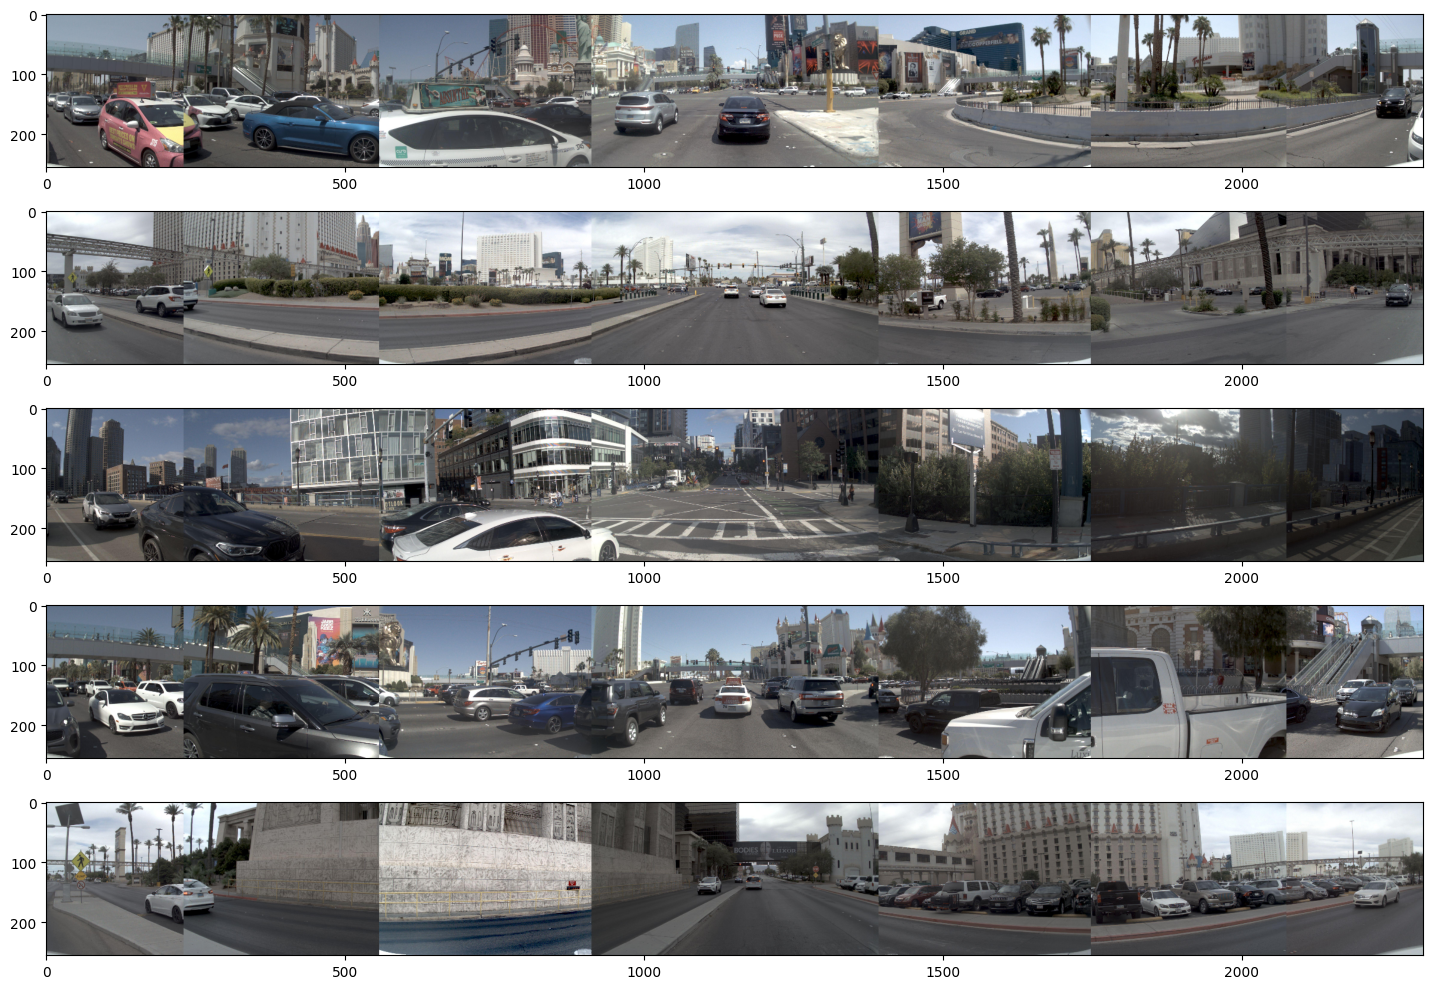

In [57]:
img_root_0 = './viz_sample/2ca53077a0a35b6d/2021.07.16.18.19.22_veh-35_00440_00858/3'
img_root_1 = './viz_sample/762599cde95156ff/2021.06.07.18.53.26_veh-26_00005_00427/3'
img_root_2 = './viz_sample/8212323415cf509a/2021.10.01.19.16.42_veh-28_03307_03808/3'
img_root_3 = './viz_sample/ac0c803827d65b80/2021.05.12.22.00.38_veh-35_01008_01518/3'
img_root_4 = './viz_sample/ead69cf7d81b5a39/2021.06.07.18.53.26_veh-26_00005_00427/3'

img_root = [img_root_0,img_root_1,img_root_2,img_root_3,img_root_4]

fig, axs = plt.subplots(nrows=len(img_root), ncols=1, figsize=(30, 10))
for i in range(len(img_root)):
    imgs = load_image(img_root[i])

    # Pseudolab Version
    pdl_resized_image, pdl_stitched_image = crop_by_custom(imgs, width=[4,266,266,266], verbose=False)
    axs[i].imshow(pdl_resized_image)

plt.tight_layout()

## Panorama Stitching - pip Stitching


https://github.com/OpenStitching/stitching_tutorial/blob/master/Stitching%20Tutorial.ipynb

In [2]:
from matplotlib import pyplot as plt
import cv2 as cv
import numpy as np

def plot_image(img, figsize_in_inches=(5,5)):
    fig, ax = plt.subplots(figsize=figsize_in_inches)
    ax.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.show()
    
def plot_images(imgs, figsize_in_inches=(5,5)):
    fig, axs = plt.subplots(1, len(imgs), figsize=figsize_in_inches)
    for col, img in enumerate(imgs):
        axs[col].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.show()

In [27]:
from stitching.images import Images

img_root_0 = './viz_sample/2ca53077a0a35b6d/2021.07.16.18.19.22_veh-35_00440_00858/3'
img_root_1 = './viz_sample/762599cde95156ff/2021.06.07.18.53.26_veh-26_00005_00427/3'       #
img_root_2 = './viz_sample/8212323415cf509a/2021.10.01.19.16.42_veh-28_03307_03808/3'
img_root_3 = './viz_sample/ac0c803827d65b80/2021.05.12.22.00.38_veh-35_01008_01518/3'       # l1 l0 f0 r0 r1
img_root_4 = './viz_sample/ead69cf7d81b5a39/2021.06.07.18.53.26_veh-26_00005_00427/3'

img_root_5 = './viz_sample/9f709e2d66125edf/2021.08.17.17.17.01_veh-45_02314_02798/3'
img_root_6 = './viz_sample/66b2dd7d28c95fa2/2021.06.14.16.48.02_veh-12_04978_05337/3'
img_root_7 = './viz_sample/305cefb5470d56eb/2021.06.07.18.53.26_veh-26_00005_00427/3'
img_root_8 = './viz_sample/a8b0dc227e145d5a/2021.07.24.23.50.16_veh-17_01696_02071/3' 
img_root_9 = './viz_sample/82f3424ff76453d8/2021.07.24.20.37.45_veh-17_00015_00375/3'       # l2 l1 l0 f0

img_root = img_root_9

img_paths = [
    f'{img_root}/cam_l2.jpeg', f'{img_root}/cam_l1.jpeg', f'{img_root}/cam_l0.jpeg', 
    f'{img_root}/cam_f0.jpeg',
    f'{img_root}/cam_r0.jpeg', f'{img_root}/cam_r1.jpeg', f'{img_root}/cam_r2.jpeg',
]
images = Images.of(img_paths)

# medium_imgs = list(images.resize(Images.Resolution.MEDIUM))
medium_imgs = list(images.resize(Images.Resolution.MEDIUM))
low_imgs = list(images.resize(Images.Resolution.LOW))
final_imgs = list(images.resize(Images.Resolution.FINAL))

original_size = images.sizes[0]
medium_size = images.get_image_size(medium_imgs[0])
low_size = images.get_image_size(low_imgs[0])
final_size = images.get_image_size(final_imgs[0])

# plot_images(low_imgs, (20,20))

print(f"Original Size: {original_size}  -> {'{:,}'.format(np.prod(original_size))} px ~ 1 MP")
print(f"Medium Size:   {medium_size}  -> {'{:,}'.format(np.prod(medium_size))} px ~ 0.6 MP")
print(f"Low Size:      {low_size}   -> {'{:,}'.format(np.prod(low_size))} px ~ 0.1 MP")
print(f"Final Size:    {final_size}  -> {'{:,}'.format(np.prod(final_size))} px ~ 1 MP")

from stitching.feature_detector import FeatureDetector

finder = FeatureDetector()
features = [finder.detect_features(img) for img in medium_imgs]
keypoints_center_img = finder.draw_keypoints(medium_imgs[1], features[1])

# plot_image(keypoints_center_img, (6,4))

from stitching.feature_detector import FeatureDetector

finder = FeatureDetector()
features = [finder.detect_features(img) for img in medium_imgs]
keypoints_center_img = finder.draw_keypoints(medium_imgs[0], features[0])

# plot_image(keypoints_center_img, (6,4))

from stitching.feature_matcher import FeatureMatcher

matcher = FeatureMatcher()
matches = matcher.match_features(features)

# fig, ax = plt.subplots(figsize=(3,3))
# ax.imshow(matcher.get_confidence_matrix(matches))

all_relevant_matches = matcher.draw_matches_matrix(medium_imgs, features, matches, conf_thresh=1, 
                                                   inliers=True, matchColor=(0, 255, 0))

for idx1, idx2, img in all_relevant_matches:
    print(f"Matches Image {idx1+1} to Image {idx2+1}")
    # plot_image(img, (4,2))

from stitching.subsetter import Subsetter

subsetter = Subsetter()
dot_notation = subsetter.get_matches_graph(images.names, matches)
print(dot_notation)

indices = subsetter.get_indices_to_keep(features, matches)

medium_imgs = subsetter.subset_list(medium_imgs, indices)
low_imgs = subsetter.subset_list(low_imgs, indices)
final_imgs = subsetter.subset_list(final_imgs, indices)
features = subsetter.subset_list(features, indices)
matches = subsetter.subset_matches(matches, indices)

images.subset(indices)

print(images.names)
# fig, ax = plt.subplots(figsize=(3,3))
# ax.imshow(matcher.get_confidence_matrix(matches))

Original Size: (1920, 1080)  -> 2,073,600 px ~ 1 MP
Medium Size:   (1033, 581)  -> 600,173 px ~ 0.6 MP
Low Size:      (422, 237)   -> 100,014 px ~ 0.1 MP
Final Size:    (1920, 1080)  -> 2,073,600 px ~ 1 MP
Matches Image 1 to Image 2
Matches Image 3 to Image 4
Matches Image 6 to Image 7
graph matches_graph{
"cam_l2.jpeg" -- "cam_l1.jpeg"[label="Nm=110, Ni=50, C=1.21951"];
"cam_l0.jpeg" -- "cam_f0.jpeg"[label="Nm=47, Ni=23, C=1.04072"];
"cam_r1.jpeg" -- "cam_r2.jpeg"[label="Nm=44, Ni=32, C=1.50943"];
"cam_r0.jpeg";
}
['./viz_sample/82f3424ff76453d8/2021.07.24.20.37.45_veh-17_00015_00375/3/cam_l2.jpeg', './viz_sample/82f3424ff76453d8/2021.07.24.20.37.45_veh-17_00015_00375/3/cam_l1.jpeg']


In [28]:
from stitching.camera_estimator import CameraEstimator
from stitching.camera_adjuster import CameraAdjuster
from stitching.camera_wave_corrector import WaveCorrector

camera_estimator = CameraEstimator()
camera_adjuster = CameraAdjuster()
wave_corrector = WaveCorrector()

cameras = camera_estimator.estimate(features, matches)
cameras = camera_adjuster.adjust(features, matches, cameras)
cameras = wave_corrector.correct(cameras)

In [29]:
from stitching.warper import Warper

warper = Warper()

In [30]:
warper.set_scale(cameras)

In [31]:
low_sizes = images.get_scaled_img_sizes(Images.Resolution.LOW)
camera_aspect = images.get_ratio(Images.Resolution.MEDIUM, Images.Resolution.LOW)  # since cameras were obtained on medium imgs

warped_low_imgs = list(warper.warp_images(low_imgs, cameras, camera_aspect))
warped_low_masks = list(warper.create_and_warp_masks(low_sizes, cameras, camera_aspect))
low_corners, low_sizes = warper.warp_rois(low_sizes, cameras, camera_aspect)

In [32]:
final_sizes = images.get_scaled_img_sizes(Images.Resolution.FINAL)
camera_aspect = images.get_ratio(Images.Resolution.MEDIUM, Images.Resolution.FINAL)

warped_final_imgs = list(warper.warp_images(final_imgs, cameras, camera_aspect))
warped_final_masks = list(warper.create_and_warp_masks(final_sizes, cameras, camera_aspect))
final_corners, final_sizes = warper.warp_rois(final_sizes, cameras, camera_aspect)

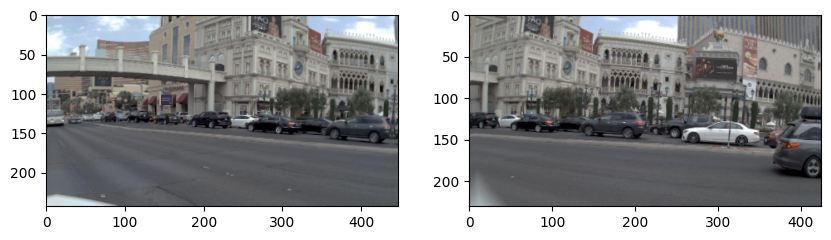

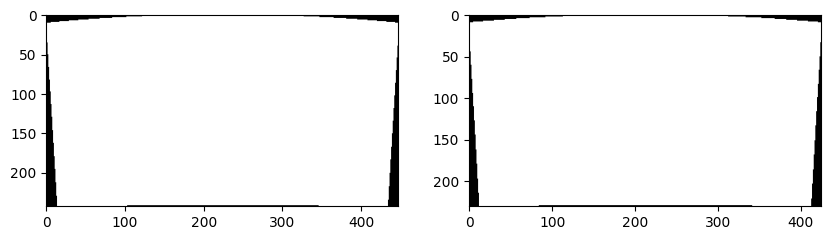

In [33]:
plot_images(warped_low_imgs, (10,10))
plot_images(warped_low_masks, (10,10))

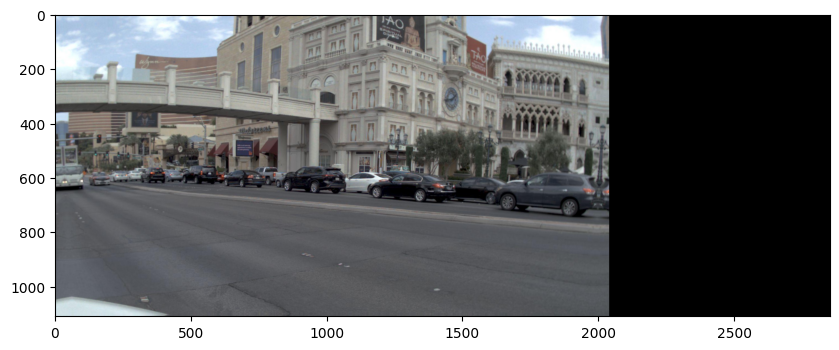

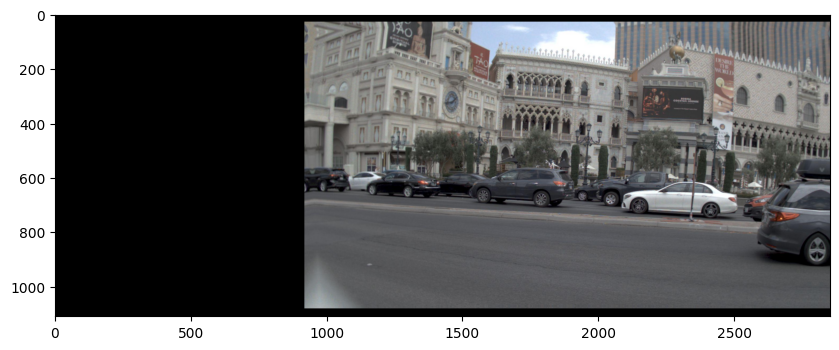

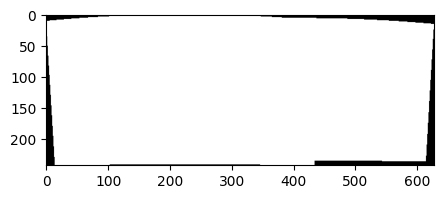

Rectangle(x=14, y=15, width=600, height=221)


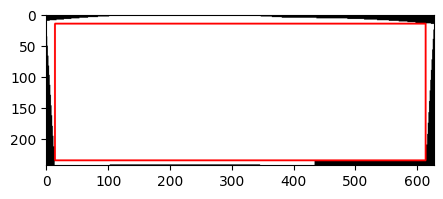

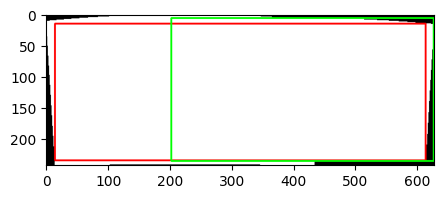

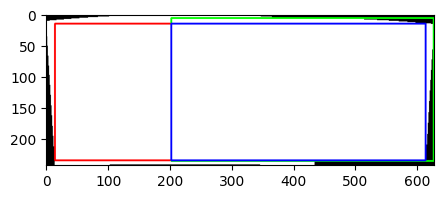

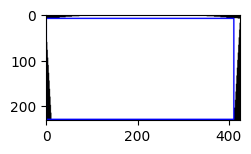

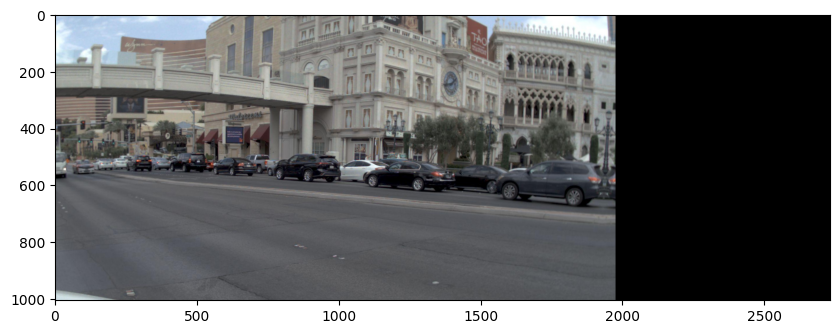

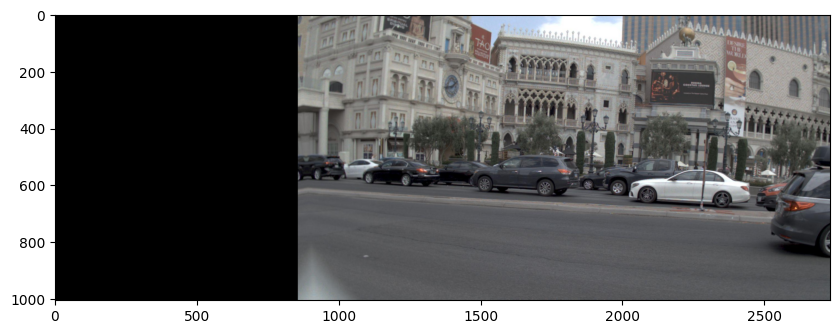

In [34]:
from stitching.timelapser import Timelapser

timelapser = Timelapser('as_is')
timelapser.initialize(final_corners, final_sizes)

for img, corner in zip(warped_final_imgs, final_corners):
    timelapser.process_frame(img, corner)
    frame = timelapser.get_frame()
    plot_image(frame, (10,10))

from stitching.cropper import Cropper

cropper = Cropper()

mask = cropper.estimate_panorama_mask(warped_low_imgs, warped_low_masks, low_corners, low_sizes)
plot_image(mask, (5,5))

lir = cropper.estimate_largest_interior_rectangle(mask)

lir = cropper.estimate_largest_interior_rectangle(mask)
print(lir)

plot = lir.draw_on(mask, size=2)
plot_image(plot, (5,5))

low_corners = cropper.get_zero_center_corners(low_corners)
rectangles = cropper.get_rectangles(low_corners, low_sizes)

plot = rectangles[1].draw_on(plot, (0, 255, 0), 2)  # The rectangle of the center img
plot_image(plot, (5,5))

overlap = cropper.get_overlap(rectangles[1], lir)
plot = overlap.draw_on(plot, (255, 0, 0), 2)
plot_image(plot, (5,5))

intersection = cropper.get_intersection(rectangles[1], overlap)
plot = intersection.draw_on(warped_low_masks[1], (255, 0, 0), 2)
plot_image(plot, (2.5,2.5))

cropper.prepare(warped_low_imgs, warped_low_masks, low_corners, low_sizes)

cropped_low_masks = list(cropper.crop_images(warped_low_masks))
cropped_low_imgs = list(cropper.crop_images(warped_low_imgs))
low_corners, low_sizes = cropper.crop_rois(low_corners, low_sizes)

lir_aspect = images.get_ratio(Images.Resolution.LOW, Images.Resolution.FINAL)  # since lir was obtained on low imgs
cropped_final_masks = list(cropper.crop_images(warped_final_masks, lir_aspect))
cropped_final_imgs = list(cropper.crop_images(warped_final_imgs, lir_aspect))
final_corners, final_sizes = cropper.crop_rois(final_corners, final_sizes, lir_aspect)

timelapser = Timelapser('as_is')
timelapser.initialize(final_corners, final_sizes)

for img, corner in zip(cropped_final_imgs, final_corners):
    timelapser.process_frame(img, corner)
    frame = timelapser.get_frame()
    plot_image(frame, (10,10))

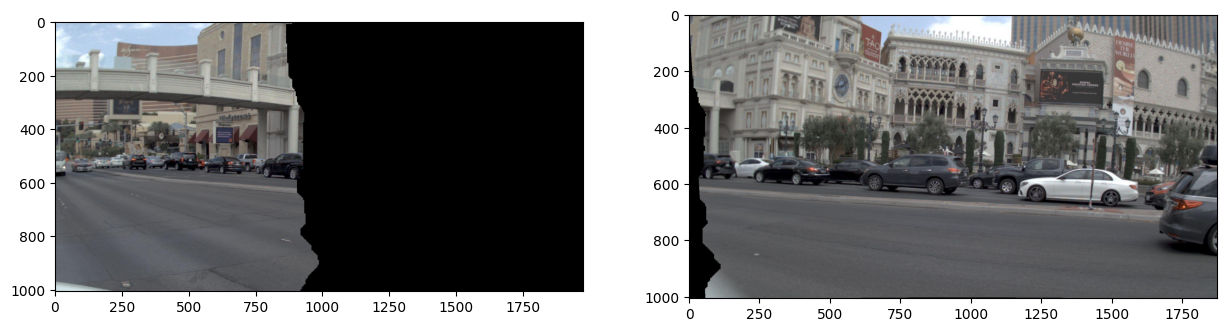

In [35]:
from stitching.seam_finder import SeamFinder

seam_finder = SeamFinder()

seam_masks = seam_finder.find(cropped_low_imgs, low_corners, cropped_low_masks)
seam_masks = [seam_finder.resize(seam_mask, mask) for seam_mask, mask in zip(seam_masks, cropped_final_masks)]

seam_masks_plots = [SeamFinder.draw_seam_mask(img, seam_mask) for img, seam_mask in zip(cropped_final_imgs, seam_masks)]
plot_images(seam_masks_plots, (15,10))

In [36]:

from stitching.exposure_error_compensator import ExposureErrorCompensator

compensator = ExposureErrorCompensator()

compensator.feed(low_corners, cropped_low_imgs, cropped_low_masks)

compensated_imgs = [compensator.apply(idx, corner, img, mask) 
                    for idx, (img, mask, corner) 
                    in enumerate(zip(cropped_final_imgs, cropped_final_masks, final_corners))]

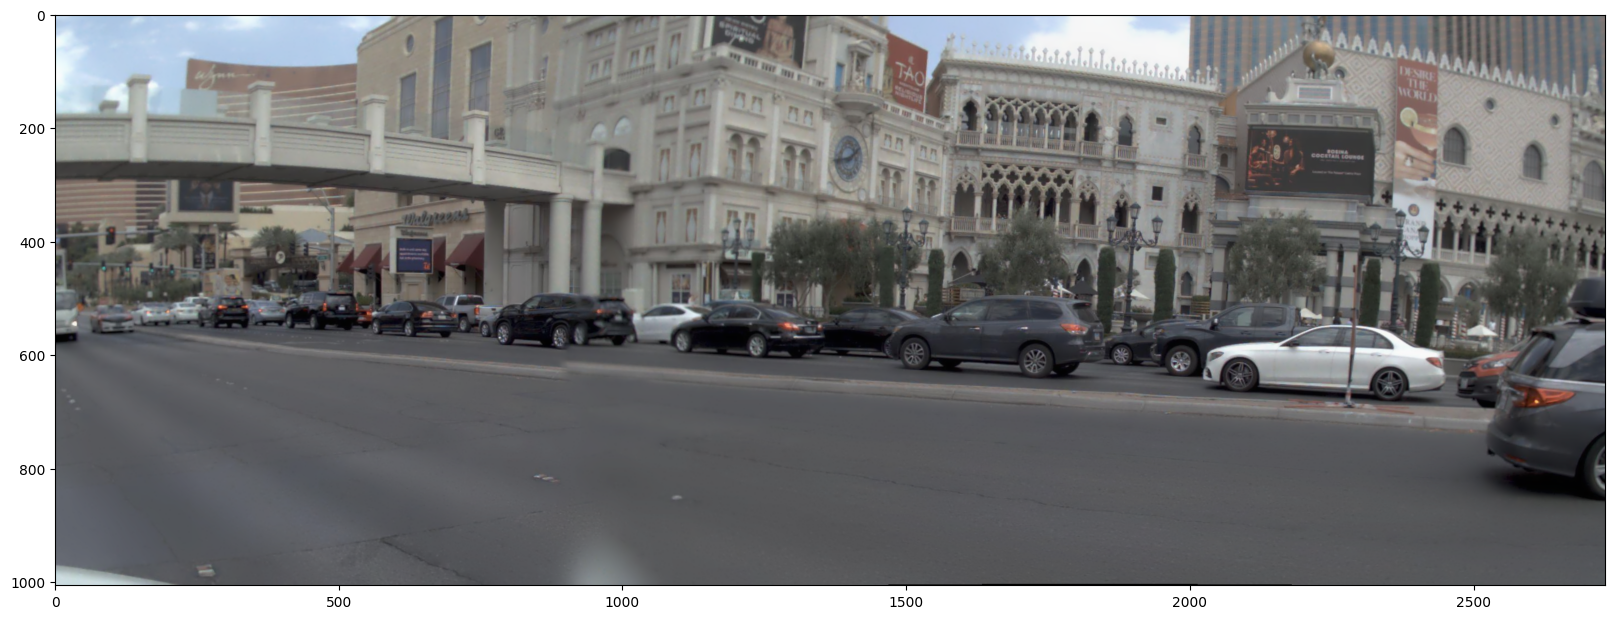

In [37]:
from stitching.blender import Blender

blender = Blender()
blender.prepare(final_corners, final_sizes)
for img, mask, corner in zip(compensated_imgs, seam_masks, final_corners):
    blender.feed(img, mask, corner)
panorama, _ = blender.blend()

plot_image(panorama, (20,20))


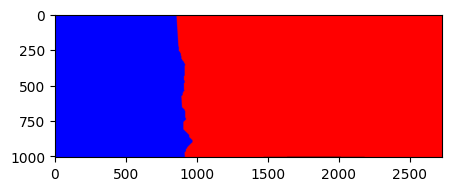

In [38]:
blended_seam_masks = seam_finder.blend_seam_masks(seam_masks, final_corners, final_sizes)
plot_image(blended_seam_masks, (5,5))

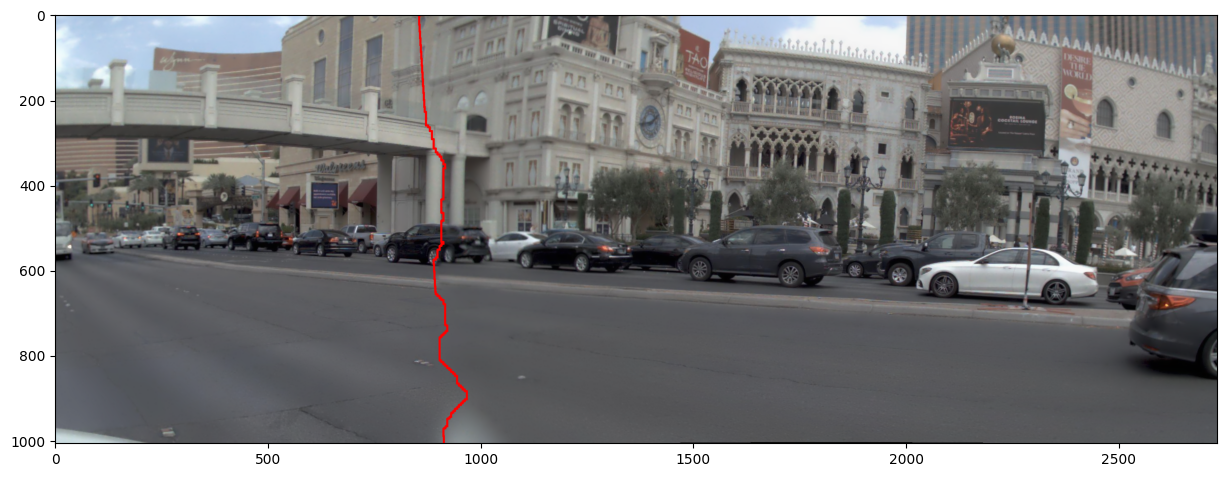

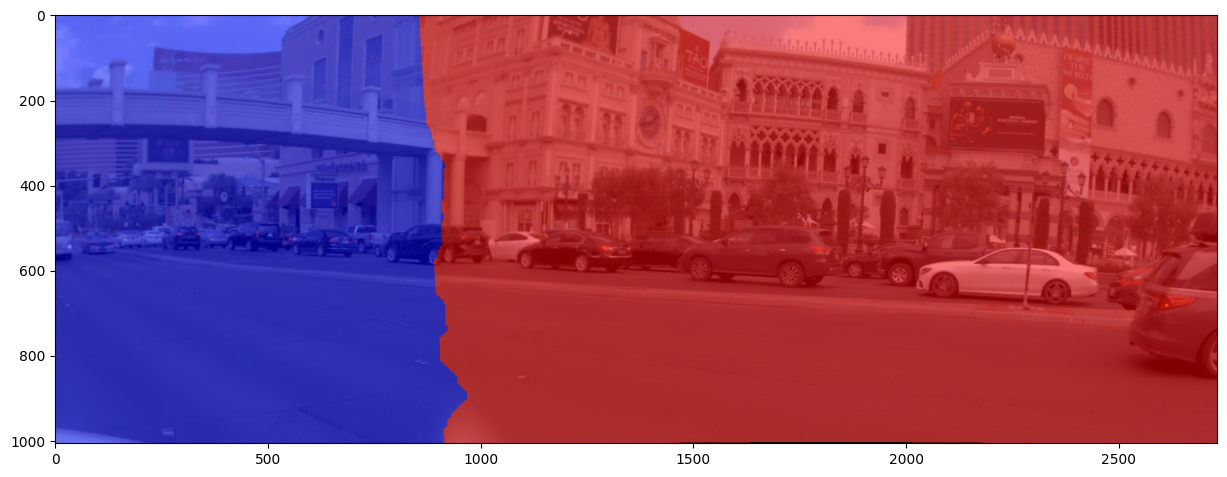

In [39]:
plot_image(seam_finder.draw_seam_lines(panorama, blended_seam_masks, linesize=3), (15,10))
plot_image(seam_finder.draw_seam_polygons(panorama, blended_seam_masks), (15,10))

## Panorama Stitching

In [7]:
from stitching import Stitcher
stitcher = Stitcher()

img_list = [imgs['cam_l2'],imgs['cam_l1'],imgs['cam_l0'],imgs['cam_f0'],imgs['cam_r0'],imgs['cam_r1'],imgs['cam_r2']]
# img_list = [imgs['cam_l0'],imgs['cam_f0'],imgs['cam_r0']]
panorama = stitcher.stitch(img_list)

fig, ax = plt.subplots(figsize=(18, 2))
ax.imshow(panorama)

In [5]:
import matplotlib.pyplot as plt

path = '/Users/hyeongkyunkim/Desktop/21fd55122da2501d/pseudolab_feature.gz'

with gzip.open(path, "rb") as f:
    data_dict: Dict[str, torch.Tensor] = pickle.load(f)
    
print(data_dict['camera_feature'].shape)
img = data_dict['camera_feature'].numpy()
img = np.transpose(img, (1,2,0))
print(img.shape)

plt.imshow(img)